<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Competitive_DS/blob/week_4/Competitive_ML4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.3.3
Для борьбы с переобучением мы можем добавлять случайность в модель, что сделает её более устойчивой к выбросам. Семейство параметров colsample_by* отвечает за количество (подмножество) признаков, которое будет использовано для построениия определенного уровня дерева. Могут принимать значения от 0 до 1 (доля признаков, которая будет использована) и действуют кумулятивно, т.е. на каждом уровне отбрасывается указанная доля фичей, которые были на предыдущем уровне.

Вопрос: Сколько признаков останется для выбора после всех разделений, при указанных значениях параметров?

{'colsample_bytree':0.1, 'colsample_bylevel':0.5, 'colsample_bynode':0.5}

Изначально в модель подали 1000 признаков.

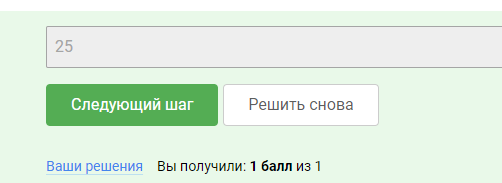

# 4.3.4

В отличие от LightGBM, в XGBoost дефолтные значения праметров, отвечающих за dropout равны нулю. И если их не изменить, то бустинг будет работать в режиме gbtree, даже если вы указали booster=dart (вот такая странная особенность).

Выберите из списка названия 2-х параметров, значение одного из которых (любого) надо задать отличное от дефолтного, чтобы модель заработала в режиме dart. Будем считать, что booster=dart уже установлен.

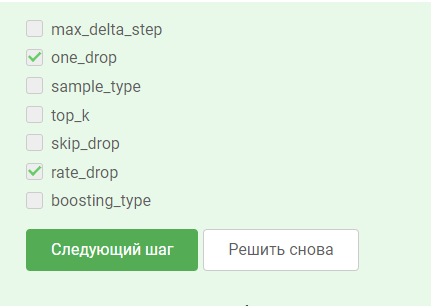

# 4.3.5

В XGBoost из коробки поддерживаются метрики из библиотеки sklearn без дополнительных танцев с бубном. Заполните пропуски (EMPTY), чтобы использовать реализацию Median absolute error regression loss из библиотеки scikit-learn для обучения XGBRegressor().

In [ ]:
from sklearn.EMPTY1 import EMPTY2


model = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=EMPTY3,
)

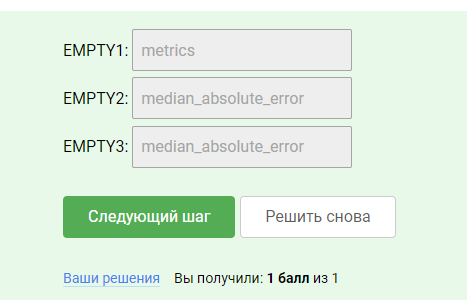

# 4.3.6

Custom eval function в XGBoost
По классике: изучаем официальный туториал - пишем кастомную метрику - понимаем почему 1 балл за задачу.

Задача:  Реализуйте функцию custom_rmsle_eval(), которую можно подать в качестве параметра custom_metric в функцию xgb.train().

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


In [ ]:
cat_cols = ['car_id', 'model', 'car_type', 'fuel_type']
drop_cols = cat_cols + ['target_class', 'target_reg']

In [ ]:
X = df.drop(drop_cols, axis=1)
y = df['target_reg']

In [ ]:
X.head()

,car_rating,year_to_start,riders,year_to_work
0,3.78,2015,76163,2021
1,3.90,2015,78218,2021
2,6.30,2012,23340,2017
3,4.04,2011,1263,2020
4,4.70,2012,26428,2017


In [ ]:
y.head()

0    108.53
1     35.20
2     38.62
3     30.34
4     30.45
Name: target_reg, dtype: float64

In [ ]:
# y = y.astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
dtest = xgb.DMatrix(X_test, y_test, nthread=-1)

In [ ]:
# метки получаем методом get_label()
def custom_rmsle_eval(predictions, dmat):
    labels = dmat.get_label()
    predictions[predictions < -1] = -1 + 1e-6
    elements = np.power(np.log1p(labels) - np.log1p(predictions), 2)
    return 'RMSLE', float(np.sqrt(np.sum(elements) / len(labels)))

In [ ]:
# def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
#     ''' Root mean squared log error metric.'''
#     y = dtrain.get_label()
#     predt[predt < -1] = -1 + 1e-6
#     elements = np.power(np.log1p(y) - np.log1p(predt), 2)
#     return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [ ]:
xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=10,
          # obj=squared_log,
          feval=custom_rmsle_eval,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
          # evals_result=results
          )

[0]	dtrain-RMSLE:1.12270	dtest-RMSLE:1.14081
[1]	dtrain-RMSLE:0.67631	dtest-RMSLE:0.70266
[2]	dtrain-RMSLE:0.48115	dtest-RMSLE:0.51785
[3]	dtrain-RMSLE:0.38752	dtest-RMSLE:0.43683
[4]	dtrain-RMSLE:0.34312	dtest-RMSLE:0.39948
[5]	dtrain-RMSLE:0.32266	dtest-RMSLE:0.38378
[6]	dtrain-RMSLE:0.31425	dtest-RMSLE:0.37799
[7]	dtrain-RMSLE:0.30456	dtest-RMSLE:0.37848
[8]	dtrain-RMSLE:0.30282	dtest-RMSLE:0.37795
[9]	dtrain-RMSLE:0.30125	dtest-RMSLE:0.37789


# 4.3.7

Extra-hard task: custom Log-cosh loss.
Чтобы решить эту задачу, нужно нащупать точку xG и долго массировать её гиперболическим секансом 🫣. Или просто взять первую и вторую производные от той страшной формулы.

Задача:  Реализуйте функцию custom_log_cosh_loss(), которую можно подать в качестве параметра obj в функцию xgb.train().

Log-cosh - это функция потерь, которая используется в задачах регрессии и является более гладкой, чем L2. Вычисляется как логарифм гиперболического косинуса ошибки предсказания по следующей формуле:  

In [ ]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [ ]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    n = len(predt)
    return n * np.tanh(predt - y)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    n = len(predt)
    return n * (1 / (np.cosh(predt - y) ** 2))

def custom_log_cosh_loss(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [ ]:
predt = np.array([0.9, .6, .8])
y = np.array([1, .8, 3])
n = 3
n * np.tanh(predt - y)

array([-0.29900398, -0.59212596, -2.92722939])

In [ ]:
np.cosh(predt - y) #** 2

array([1.00500417, 1.02006676, 4.56790833])

In [ ]:
xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=10,
          obj=custom_log_cosh_loss,
          feval=custom_rmsle_eval,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
          # evals_result=results
          )

[0]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[1]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[2]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[3]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[4]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[5]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[6]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[7]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[8]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874
[9]	dtrain-RMSLE:3.37292	dtest-RMSLE:3.38874


In [ ]:
import pandas as pd
import numpy as np

# метки получаем методом get_label()
def gradient(predt, dtrain):
    y = dtrain.get_label()
    n = len(predt)
    return n * np.tanh(predt - y)

def hessian(predt, dtrain):
    y = dtrain.get_label()
    n = len(predt)
    return n * (1 / (np.cosh(predt - y) ** 2))

def custom_log_cosh_loss(predt, dtrain):
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, 